# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


In [248]:
m = 1
A = 0.001#0.0492646484375#0.001#0.049375#5#0.0492645084166179#0.049264507293701174#0.049264508247375494#0.04925#0.0493#0.001#0.049375#0.07#0.05#0.1124921875#0.125
run = 1

1

In [249]:
global loggrid=true#true
global bisection=false
global meshrefinement=false;

In [250]:
using Quadmath, Printf

res=m;
N=2.0^m*100.0#2.0^m*1000.0/2.0#Nt=2.0^m*1000.0/2.0
Xf=1.0#Float128(1.0);

dx=Xf/N#Float128(Xf/N);
if loggrid==false
    dt=0.5*round(dx,digits=10)
else
    dt=0.1*round(dx,digits=10)
end
Nt=2.0^m*100.0#2.0^m*1000.0/2.0#Nt=2.0^m*1000.0/2.0
Tf=Nt*dt; #final time
#print(Tf)

In [251]:
print(N)

200.0

In [252]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)

dx =0.005
dt =0.0005
dx/dt =10.0


In [253]:
global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA" #~/data/ritapsantos/
#global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

# Grid

In [254]:
using Printf
include("./ScalarField.jl");

In [255]:
ori=0.0#Float128(0.0)#0.0;
initX1 = nothing
N=int(N)
initX1=range(ori, stop=Xf, step=dx);
#initX1=create_range(ori,Xf,dx,N)
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)
#initX=create_range(ori-3.0*dx,Xf+3.0*dx,dx,N+6)

L=length(initX);
println("step size is  ", dx)
println("the time step is ", dt)

if loggrid==true
    global originalX=initX
    xtilde=gridfunc(initX1)
    initX1=xtilde
    initX=collect(initX)
    initX[4:L-3]=xtilde
end;

step size is  0.005
the time step is 0.0005


# Initial data of m β Ψ and Ψ,x

In [256]:
using Dierckx
using Quadmath


####
#initm=Array{Float128}(undef, L)
#initbeta=Array{Float128}(undef, L)
#initpsi=Array{Float128}(undef, L)
#initderpsi=Array{Float128}(undef, L)
initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initderpsi=zeros(L);

state_array=[initm initbeta initpsi initderpsi initX];

#PSI
r0=0.7#0.01#0.7#0.01#0.7#0.7#0.7#0.01#0.7#0.3
sigma=0.3
initpsi[4:L-3] = init_gaussian(initX1,r0,sigma,A)

state_array[:,3] = initpsi
state_array = ghost(state_array)

#PSI,X FROM PSI
initderpsi[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)
state_array[:,4] = initderpsi
state_array=ghost(state_array)

####

derpsi_func = Spline1D(initX[4:L-3], state_array[4:L-3,4],  k=4);

In [257]:
y0=[0 0 0]

state_array[4:L-3,1:3] = n_rk4wrapper(RHS,y0,initX[4:L-3],0,derpsi_func,state_array[:,:]);

state_array = ghost(state_array);

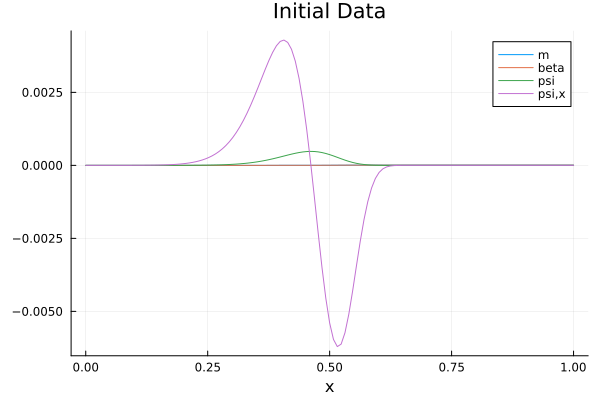

In [258]:
using Plots #showing initial data and the initial status of the horizon finder
plot(initX[4:L-3], state_array[4:L-3,1:4], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [259]:
using CSV, Tables, Printf
#CSV.write(dir*"/time_step0.csv", Tables.table(transpose(Matrix(state_array))), writeheader=false)
#CSV.write(dir*"/res$res/time_step0.csv", Tables.table(state_array), writeheader=false)

global files=["m", "beta", "psi", "derpsi"]

print_muninn(files, 0, state_array[:,1:5],res,"w")

In [260]:
time=0.0
criticality=0.0
explode=0.0
evol_stats = [criticality A sigma r0 time explode run]
monitor_ratio = zeros(L)
CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=true, header=["criticality", "A", "sigma", "r0", "time", "explode", "run"])

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv"

In [261]:
ginit=speed(initX,state_array[:,1],state_array[:,2])
println(update_dt(initX,state_array[:,1],state_array[:,2],dx,ginit)/dt)

0.12338273929230742


In [262]:
using Base.Threads
Threads.nthreads()

4

 ## Time evolution

In [263]:
initX

207-element Vector{Float64}:
 -0.015
 -0.01
 -0.005
  0.0
  6.168375916970614e-5
  0.0002467198171342
  0.0005550625190150482
  0.0009866357858642205
  0.001541333133436018
  0.002219017698460002
  0.0030195222724101467
  0.0039426493427611176
  0.0049881711417212315
  ⋮
  0.996057350657239
  0.9969804777275899
  0.99778098230154
  0.998458666866564
  0.9990133642141358
  0.9994449374809851
  0.9997532801828658
  0.9999383162408303
  1.0
  1.005
  1.01
  1.015

In [264]:
7500 gridpoints evenly spaced means

LoadError: syntax: extra token "gridpoints" after end of expression

fixed grid

In [265]:
finaltime=1.3#2.0#1.3#1.6#2#1.3#0.08*2#0.005*10*5#1#0.9#0.8#0.04*5*4#length(T)-1
evol_stats, T_interp = timeevolution(state_array,finaltime,run);#timeevolution(state_array,finaltime,dir*"/res$res",run,auxstate_array);
#CSV.write(dir*"/timearray$res.csv", Tables.table(T_interp), writeheader=false);



iteration 100 dt is 6.169136964615371e-5, t=0.006169136964615376 speed is 0.49993831814327333, dx/dt=81.04861390951038


iteration 200 dt is 6.169136964615371e-5, t=0.012338273929230708 speed is 0.49993831814327333, dx/dt=81.04861390951038


iteration 300 dt is 6.169136964615371e-5, t=0.01850741089384602 speed is 0.49993831814327333, dx/dt=81.04861390951038


iteration 400 dt is 6.169136964615371e-5, t=0.02467654785846133 speed is 0.49993831814327333, dx/dt=81.04861390951038


iteration 500 dt is 6.169136964615371e-5, t=0.03084568482307664 speed is 0.49993831814327333, dx/dt=81.04861390951038


iteration 600 dt is 6.169136964615371e-5, t=0.037014821787692276 speed is 0.49993831814327333, dx/dt=81.04861390951038


iteration 700 dt is 6.169136964615371e-5, t=0.04318395875230793 speed is 0.49993831814327333, dx/dt=81.04861390951038


iteration 800 dt is 6.169136964615371e-5, t=0.04935309571692359 speed is 0.49993831814327333, dx/dt=81.04861390951038


iteration 900 dt is 6.1691369646153

 ## Movie of the evolution

In [19]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 0:100:3800#870
    
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    
    #functions3=DataFrame(CSV.File("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/bisectionsearch/run1"*"/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
        plot5=functions3.Column5[4:L-3];
    temp=round(n*dt,digits=2)
    plot!(initX1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"], title="$temp", ylim=[-0.01, 0.01],xlim=[0, 1])#, xlim=[0, 0.1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 10)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step0.csv" is not a valid file or doesn't exist

In [ ]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 10:10:1000#length(T)-1
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/monitor_ratio$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
    
    plot!(initX1, [plot1], labels=["monitor ratio"], ylim=[0, 1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 5)

# New test

In [158]:
include("./ScalarField.jl");

function ff(x)

    return x^2

end
function gridd(x)

    #return(1/2+1/2*cos(pi*(1-0.9*x)))
    return(1/2 .+ 1/2 .* cos.(pi .* (1 .- x)))

end;

In [159]:
res=1

dx=0.01

x=range(-3*dx,1+3*dx,step=dx)

y=ff.(x);

In [160]:
L=length(x)
aux=zeros(L)


for i in 4:L-3

    aux[i]=Dertest(y,i,x)

end

println(aux[4:L-3]);
xnew=collect(x)
xnew[4:L-3]=gridd(x[4:L-3])

#ynew=ff.(xnew);
ynew=[ff.(xnew) zeros(L)]

[-5.421010862427522e-18, 0.02, 0.04, 0.05999999999999999, 0.08000000000000002, 0.10000000000000005, 0.1199999999999999, 0.1400000000000001, 0.16000000000000003, 0.1799999999999999, 0.2000000000000001, 0.22, 0.2399999999999999, 0.25999999999999995, 0.2800000000000004, 0.29999999999999966, 0.32000000000000006, 0.34000000000000047, 0.35999999999999943, 0.3800000000000001, 0.4000000000000004, 0.41999999999999915, 0.44000000000000006, 0.46000000000000085, 0.4799999999999994, 0.5, 0.5199999999999999, 0.5399999999999997, 0.560000000000002, 0.5799999999999987, 0.6, 0.6199999999999999, 0.6399999999999997, 0.6600000000000003, 0.6800000000000018, 0.699999999999998, 0.7199999999999999, 0.7399999999999998, 0.7600000000000002, 0.7800000000000008, 0.8000000000000017, 0.8199999999999964, 0.8399999999999997, 0.8600000000000003, 0.8800000000000008, 0.9, 0.9200000000000029, 0.9399999999999983, 0.9599999999999989, 0.9799999999999994, 1.0, 1.0200000000000005, 1.0400000000000011, 1.059999999999999, 1.079999

107×2 Matrix{Float64}:
 0.0009       0.0
 0.0004       0.0
 0.0001       0.0
 0.0          0.0
 6.08707e-8   0.0
 9.7345e-7    0.0
 4.92404e-6   0.0
 1.55445e-5   0.0
 3.78942e-5   0.0
 7.84354e-5   0.0
 0.000145001  0.0
 0.000246754  0.0
 0.000394148  0.0
 ⋮            
 0.96883      0.0
 0.976062     0.0
 0.982366     0.0
 0.987726     0.0
 0.99213      0.0
 0.995567     0.0
 0.998028     0.0
 0.999507     0.0
 1.0          0.0
 1.0201       0.0
 1.0404       0.0
 1.0609       0.0

In [161]:
spl=Spline1D(xnew[4:L-3],ynew[4:L-3],k=4)
spl=[spl spl]
auxnew=zeros(L);
k=1

for i in 4:L-3
    auxnew[i]=unevenDer(ynew,i,k,xnew,spl)
end

println(" ")
println(auxnew[4:L-3])
println(" ")
println(2 .* xnew[4:L-3])

warnign at ori, i is 6
warnign at ori, i is 7
warnign at ori, i is 8
warning!, X[i]0.99778098230154i is 101
warning!, X[i]0.9990133642141358i is 102
 
[1.015648370447264e-16, 0.0005482301902749086, 0.001973271571728468, 0.0044380353969199916, 0.007885298685522223, 0.012311659404862337, 0.017712749271311282, 0.02408323806125268, 0.03141683887136893, 0.03970631432305701, 0.04894348370484647, 0.05911923104577456, 0.07022351411174863, 0.08224537431601885, 0.09517294753398073, 0.10899347581163228, 0.12369331995613629, 0.1392579729960566, 0.15567207449798479, 0.1729194257254383, 0.19098300562505244, 0.2098449876243095, 0.22948675722421108, 0.2498889303695403, 0.2710313725785885, 0.29289321881345254, 0.31545289407131144, 0.33868813467634734, 0.3625760102513108, 0.38709294634702446, 0.41221474770752714, 0.43791662214787025, 0.46417320502100506, 0.49095858424962846, 0.5182463258982851, 0.5460095002604536, 0.574220708434928, 0.6028521093652197, 0.6318754473153203, 0.6612620797547106, 0.690983005

In [162]:
L-3

104

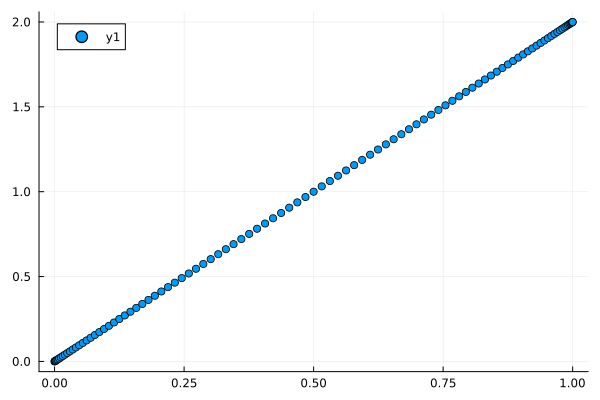

In [163]:

#plot(x,y)

scatter(xnew[4:L-3],auxnew[4:L-3])#,xlim=[0,0.2])

#plot(x[4:L-3],aux[4:L-3])

In [164]:
auxnew[L-3]

2.0000000000015